In [1]:
import pandas as pd
import numpy as np
import nltk
import pandas as pd
import re
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mitchellkijurina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mitchellkijurina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mitchellkijurina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mitchellkijurina/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Load data
df = pd.read_excel("Data.xlsx")
target = df['Orientation']

# Drop unnecessary columns
df = df.drop(['ID', 'DOI', 'PersonID', 'Orientation', 'Impact', 'Area of  research - person',
              'Area of research - publication', 'UT', 'SOURCE YEAR', 'Doc type',
              'Born', 'Position'], axis=1)

In [3]:
# Preprocessing function
def preprocess_text(text):
    # Remove special characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # Tokenize and convert to lowercase
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens
    # return ' '.join(tokens) # Return as string for tf-idf

In [4]:
# Preprocess 'TI' and 'AB' columns
df['processed_TI'] = df['TI'].apply(preprocess_text)
df['processed_AB'] = df['AB'].apply(preprocess_text)



In [5]:
# Train a Word2Vec model on the combined text data
combined_text = pd.concat([df['processed_TI'], df['processed_AB']])
w2v_model = Word2Vec(combined_text, min_count=1, vector_size=100)

# Function to convert tokens to a vector using the Word2Vec model
def tokens_to_vector(tokens):
    vector_list = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    
    if len(vector_list) == 0:
        return np.zeros(100)
    
    vector_avg = np.mean(vector_list, axis=0)
    return vector_avg

In [6]:
# # import TfidfVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Preprocess 'TI' and 'AB' columns
# df['processed_TI'] = df['TI'].apply(preprocess_text)
# df['processed_AB'] = df['AB'].apply(preprocess_text)

# # Create the TF-IDF vectorizer
# vectorizer_TI = TfidfVectorizer()
# vectorizer_AB = TfidfVectorizer()

# # Fit and transform the vectorizer on the 'TI' and 'AB' columns
# TI_vector  = vectorizer_TI.fit_transform(df['processed_TI'])
# AB_vector = vectorizer_AB.fit_transform(df['processed_AB'])

In [7]:
# Convert preprocessed tokens to vectors
df['TI_vector'] = df['processed_TI'].apply(tokens_to_vector)
df['AB_vector'] = df['processed_AB'].apply(tokens_to_vector)

# Encode the 'Gender' column using LabelEncoder
encoder = LabelEncoder()
df['encoded_gender'] = encoder.fit_transform(df['Gender'])

In [8]:
# Split the data into training, validation, and testing sets
X_TI = np.vstack(df['TI_vector'].values)
X_AB = np.vstack(df['AB_vector'].values)
X = np.hstack((X_TI, X_AB)) # Combine the two vectors
y = target.values


In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)


In [10]:
# Create the SVC classifier 
svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)
# Train the Random Forest classifier on 'TI_vector'
svm_classifier.fit(X_train, y_train)


SVC(random_state=42)

In [11]:
# Validate the classifier on the combined 'TI_vector' and 'AB_vector'
y_val_pred = svm_classifier.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation accuracy for the SVM model using word2vec", accuracy_val)


Validation accuracy for the SVM model using word2vec 0.4581005586592179


In [12]:
# Test the classifier on the test set
y_test_pred = svm_classifier.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test accuracy for the SVM model using word2vec", accuracy_test)

Test accuracy for the SVM model using word2vec 0.5195530726256983


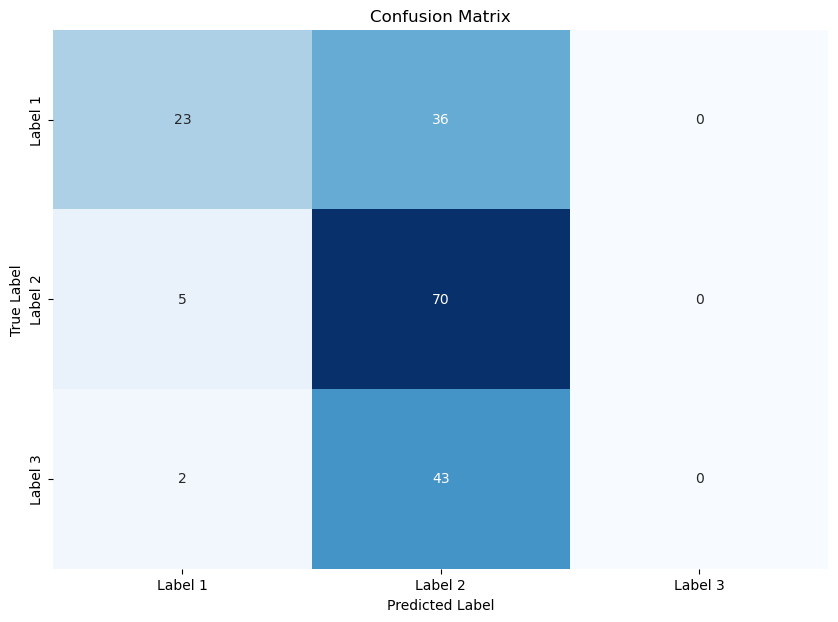

In [13]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

# Create confusion matrix plot using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Label 1', 'Label 2', 'Label 3'], yticklabels=['Label 1', 'Label 2', 'Label 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Calculate precision, recall and F1 score
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("Test set Accuracy:", accuracy_test)
print("Test set Precision:", precision)
print("Test set Recall:", recall)
print("Test set F1 Score:", f1)

Test set Accuracy: 0.5195530726256983
Test set Precision: 0.41215510812826245
Test set Recall: 0.4410546139359699
Test set F1 Score: 0.38061797752808985


/Users/mitchellkijurina/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Get the accuracy on the training data
y_train_pred = svm_classifier.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Training accuracy for the SVM model using word2vec", accuracy_train)

Training accuracy for the SVM model using word2vec 0.46706586826347307
